In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

num = 0
for root, dirs, files in os.walk("archive"):
    for file in files:
        num = num + 1

num

2481

In [2]:
import torch
from torch import nn
import torchvision 
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter 

In [3]:
writer = SummaryWriter()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.densenet = torch.hub.load('pytorch/vision:v0.6.0', 'densenet201', pretrained=True)
        for p in self.densenet.parameters():
               p.requires_grad = False
        self.densenet.classifier = nn.Identity()
        self.flatten1 = nn.Flatten()
        self.linear1 = nn.Linear(1920,128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(128,64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.linear3 = nn.Linear(64,2)
        self.sigmoid = nn.Sigmoid()
    
    
    def forward(self,x):
        x=self.densenet(x)
        x=self.flatten1(x)
        x=self.linear1(x)
        x=self.relu1(x)
        x=self.dropout1(x)
        x=self.linear2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.linear3(x)
        x=self.sigmoid(x)
        return x
        

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model = Net().to('cpu')


Using cache found in C:\Users\peter/.cache\torch\hub\pytorch_vision_v0.6.0


In [7]:
model(torch.rand((1,3,224,224)))

tensor([[0.4764, 0.4888]], grad_fn=<SigmoidBackward>)

In [8]:
model.to(device)


Net(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

In [9]:
transform = transforms.Compose(
    [ transforms.Resize((224,224)),transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])

In [10]:
num

2481

In [11]:
dataset = torchvision.datasets.ImageFolder('archive', transform=transform)
train, val, test = torch.utils.data.random_split(dataset, [1985, 248, 248])

trainloader = torch.utils.data.DataLoader(train,batch_size=20,shuffle=True,
                                           num_workers=1,drop_last = True)
valloader = torch.utils.data.DataLoader(val,batch_size=20,
                                           num_workers=1,drop_last = True)
testloader = torch.utils.data.DataLoader(test,batch_size=20,
                                           num_workers=1,drop_last = True)
images, labels = next(iter(trainloader))

In [12]:
images

tensor([[[[ 0.6471,  0.6314,  0.6000,  ...,  0.6000,  0.6157,  0.6157],
          [ 0.6235,  0.6078,  0.6000,  ...,  0.5922,  0.5922,  0.6000],
          [ 0.5843,  0.5922,  0.5922,  ...,  0.6000,  0.5843,  0.5843],
          ...,
          [ 0.8196,  0.8118,  0.7961,  ...,  0.6157,  0.6157,  0.6235],
          [ 0.8353,  0.8275,  0.8431,  ...,  0.6157,  0.6314,  0.6549],
          [ 0.8745,  0.8588,  0.8510,  ...,  0.6392,  0.6549,  0.6549]],

         [[ 0.6471,  0.6314,  0.6000,  ...,  0.6000,  0.6157,  0.6157],
          [ 0.6235,  0.6078,  0.6000,  ...,  0.5922,  0.5922,  0.6000],
          [ 0.5843,  0.5922,  0.5922,  ...,  0.6000,  0.5843,  0.5843],
          ...,
          [ 0.8196,  0.8118,  0.7961,  ...,  0.6157,  0.6157,  0.6235],
          [ 0.8353,  0.8275,  0.8431,  ...,  0.6157,  0.6314,  0.6549],
          [ 0.8745,  0.8588,  0.8510,  ...,  0.6392,  0.6549,  0.6549]],

         [[ 0.6471,  0.6314,  0.6000,  ...,  0.6000,  0.6157,  0.6157],
          [ 0.6235,  0.6078,  

In [13]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)

In [14]:
losses = []
min_valid_loss = np.inf

PATH = 'trained_model.pt'


def accuracy(predicted, labels):
    classes = torch.argmax(predicted, dim=1)
    return torch.mean((classes == labels).float())*100

for epoch in range(40):
    
    train_loss = 0.0
    running_accuracy = 0.0
    val_accuracy = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        optimizer.zero_grad()
       
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0) 
        running_accuracy += accuracy(outputs, labels)
        # print statistics
        # running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, train_loss / 2000))
            train_loss = 0.0
        epoch_loss = train_loss / len(trainloader)
        losses.append(epoch_loss)
        print(f"Epoch:{epoch} Loss:{loss}")
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    
    with torch.no_grad():
        
        for data, labels in valloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            outputs = model(data)
            loss = criterion(outputs,labels)
            valid_loss = loss.item() * data.size(0)
            val_accuracy += accuracy(outputs, labels)

        running_accuracy /= len(trainloader)
        val_accuracy /= len(valloader)
        print(f'Epoch {epoch+1} \t Training Accuracy: {running_accuracy}% \t Validation Accuracy: {val_accuracy}%')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), PATH)
        
print('Finished Training')

            

Epoch:0 Loss:0.6920251846313477
Epoch:0 Loss:0.6894634962081909
Epoch:0 Loss:0.6911458969116211
Epoch:0 Loss:0.6926489472389221
Epoch:0 Loss:0.6925353407859802
Epoch:0 Loss:0.6971968412399292
Epoch:0 Loss:0.6946038603782654
Epoch:0 Loss:0.6951241493225098
Epoch:0 Loss:0.6906704306602478
Epoch:0 Loss:0.6898704767227173
Epoch:0 Loss:0.6940914988517761
Epoch:0 Loss:0.6947934031486511
Epoch:0 Loss:0.6878706216812134
Epoch:0 Loss:0.6883471608161926
Epoch:0 Loss:0.6942071318626404
Epoch:0 Loss:0.6969870924949646
Epoch:0 Loss:0.6889172792434692
Epoch:0 Loss:0.6891701817512512
Epoch:0 Loss:0.6933296918869019
Epoch:0 Loss:0.6904455423355103
Epoch:0 Loss:0.6886521577835083
Epoch:0 Loss:0.6910063028335571
Epoch:0 Loss:0.6904866099357605
Epoch:0 Loss:0.6997655630111694
Epoch:0 Loss:0.6960299611091614
Epoch:0 Loss:0.6927241086959839
Epoch:0 Loss:0.6927992701530457
Epoch:0 Loss:0.6910141706466675
Epoch:0 Loss:0.6982094049453735
Epoch:0 Loss:0.6865857839584351
Epoch:0 Loss:0.6955456733703613
Epoch:0 

Epoch:2 Loss:0.6876950263977051
Epoch:2 Loss:0.6895582675933838
Epoch:2 Loss:0.6767522692680359
Epoch:2 Loss:0.6837759017944336
Epoch:2 Loss:0.675960898399353
Epoch:2 Loss:0.6813100576400757
Epoch:2 Loss:0.6736961603164673
Epoch:2 Loss:0.6820939183235168
Epoch:2 Loss:0.689581573009491
Epoch:2 Loss:0.6757782697677612
Epoch:2 Loss:0.6717932820320129
Epoch:2 Loss:0.6792422533035278
Epoch:2 Loss:0.6793209314346313
Epoch:2 Loss:0.6772417426109314
Epoch:2 Loss:0.6881851553916931
Epoch:2 Loss:0.6858603358268738
Epoch:2 Loss:0.6846769452095032
Epoch:2 Loss:0.6678940653800964
Epoch:2 Loss:0.68077152967453
Epoch:2 Loss:0.6809555888175964
Epoch:2 Loss:0.6859148740768433
Epoch:2 Loss:0.6837196946144104
Epoch:2 Loss:0.6730857491493225
Epoch:2 Loss:0.6775181293487549
Epoch:2 Loss:0.6760330200195312
Epoch:2 Loss:0.6975847482681274
Epoch:2 Loss:0.6710537075996399
Epoch:2 Loss:0.6837422847747803
Epoch:2 Loss:0.6758437752723694
Epoch:2 Loss:0.6707708239555359
Epoch:2 Loss:0.6671518087387085
Epoch:2 Loss

Epoch:5 Loss:0.654617428779602
Epoch:5 Loss:0.6308139562606812
Epoch:5 Loss:0.6381610035896301
Epoch:5 Loss:0.6539579033851624
Epoch:5 Loss:0.6516023874282837
Epoch:5 Loss:0.614220917224884
Epoch:5 Loss:0.6341992020606995
Epoch:5 Loss:0.6632577776908875
Epoch:5 Loss:0.6506048440933228
Epoch:5 Loss:0.618263304233551
Epoch:5 Loss:0.6497598886489868
Epoch:5 Loss:0.6536964178085327
Epoch:5 Loss:0.6355802416801453
Epoch:5 Loss:0.6495019197463989
Epoch:5 Loss:0.6338595151901245
Epoch:5 Loss:0.6364082098007202
Epoch:5 Loss:0.6309564709663391
Epoch:5 Loss:0.6321964859962463
Epoch:5 Loss:0.6590341329574585
Epoch:5 Loss:0.647883415222168
Epoch:5 Loss:0.6206045746803284
Epoch:5 Loss:0.6195553541183472
Epoch:5 Loss:0.6517999768257141
Epoch:5 Loss:0.6403580904006958
Epoch:5 Loss:0.7007766962051392
Epoch:5 Loss:0.6334598660469055
Epoch:5 Loss:0.6271843910217285
Epoch:5 Loss:0.6657528877258301
Epoch:5 Loss:0.6514192819595337
Epoch:5 Loss:0.6436488032341003
Epoch:5 Loss:0.6450732946395874
Epoch:5 Loss

Epoch:7 Loss:0.6114109754562378
Epoch:7 Loss:0.5585394501686096
Epoch:7 Loss:0.5699880123138428
Epoch:7 Loss:0.5853055715560913
Epoch:7 Loss:0.5804468989372253
Epoch:7 Loss:0.5528954267501831
Epoch:7 Loss:0.5356383323669434
Epoch:7 Loss:0.5631896257400513
Epoch:7 Loss:0.6084948778152466
Epoch:7 Loss:0.5488141775131226
Epoch:7 Loss:0.5699683427810669
Epoch:7 Loss:0.5490097999572754
Epoch:7 Loss:0.5801438093185425
Epoch:7 Loss:0.5853263735771179
Epoch:7 Loss:0.5321437120437622
Epoch:7 Loss:0.5799897909164429
Epoch:7 Loss:0.5242746472358704
Epoch:7 Loss:0.5885510444641113
Epoch:7 Loss:0.5616322755813599
Epoch:7 Loss:0.5964223146438599
Epoch:7 Loss:0.5708679556846619
Epoch:7 Loss:0.5478432774543762
Epoch:7 Loss:0.5608583688735962
Epoch:7 Loss:0.5542811155319214
Epoch:7 Loss:0.5449036359786987
Epoch:7 Loss:0.5281459093093872
Epoch:7 Loss:0.5822263956069946
Epoch:7 Loss:0.5796210169792175
Epoch:7 Loss:0.51981121301651
Epoch:7 Loss:0.5690287351608276
Epoch:7 Loss:0.5762938261032104
Epoch:7 Lo

Epoch:9 Loss:0.5001420974731445
Epoch 10 	 Training Accuracy: 86.41413879394531% 	 Validation Accuracy: 84.58333587646484%
Validation Loss Decreased(10.138965--->9.652429) 	 Saving The Model
Epoch:10 Loss:0.4366050362586975
Epoch:10 Loss:0.48056739568710327
Epoch:10 Loss:0.4844059944152832
Epoch:10 Loss:0.527473509311676
Epoch:10 Loss:0.505363941192627
Epoch:10 Loss:0.44227877259254456
Epoch:10 Loss:0.5000309944152832
Epoch:10 Loss:0.47128716111183167
Epoch:10 Loss:0.5300263166427612
Epoch:10 Loss:0.45471200346946716
Epoch:10 Loss:0.5078171491622925
Epoch:10 Loss:0.5400365591049194
Epoch:10 Loss:0.4548671245574951
Epoch:10 Loss:0.587998628616333
Epoch:10 Loss:0.46206799149513245
Epoch:10 Loss:0.43197932839393616
Epoch:10 Loss:0.41228461265563965
Epoch:10 Loss:0.5579532384872437
Epoch:10 Loss:0.5105109214782715
Epoch:10 Loss:0.42858052253723145
Epoch:10 Loss:0.47671669721603394
Epoch:10 Loss:0.4723816514015198
Epoch:10 Loss:0.5475863218307495
Epoch:10 Loss:0.4891485273838043
Epoch:10 Lo

Epoch:12 Loss:0.4176807999610901
Epoch:12 Loss:0.43380600214004517
Epoch:12 Loss:0.46532225608825684
Epoch:12 Loss:0.45415011048316956
Epoch:12 Loss:0.5651980042457581
Epoch:12 Loss:0.43220534920692444
Epoch:12 Loss:0.5167711973190308
Epoch:12 Loss:0.4126412272453308
Epoch:12 Loss:0.41319116950035095
Epoch:12 Loss:0.4947587847709656
Epoch:12 Loss:0.4480108320713043
Epoch:12 Loss:0.45196810364723206
Epoch:12 Loss:0.4906587600708008
Epoch:12 Loss:0.45227137207984924
Epoch:12 Loss:0.4769914150238037
Epoch:12 Loss:0.39569157361984253
Epoch:12 Loss:0.4272121787071228
Epoch:12 Loss:0.3732239007949829
Epoch:12 Loss:0.4329950213432312
Epoch:12 Loss:0.46924424171447754
Epoch:12 Loss:0.4830407202243805
Epoch:12 Loss:0.4807823598384857
Epoch:12 Loss:0.4760068953037262
Epoch:12 Loss:0.4241670072078705
Epoch:12 Loss:0.41092386841773987
Epoch:12 Loss:0.4631824493408203
Epoch:12 Loss:0.4975505471229553
Epoch:12 Loss:0.4259661138057709
Epoch:12 Loss:0.525150716304779
Epoch:12 Loss:0.4408486783504486
E

Epoch:14 Loss:0.4304197430610657
Epoch:14 Loss:0.4867745339870453
Epoch:14 Loss:0.44497641921043396
Epoch:14 Loss:0.44551676511764526
Epoch:14 Loss:0.4735661447048187
Epoch:14 Loss:0.39798274636268616
Epoch:14 Loss:0.39372605085372925
Epoch:14 Loss:0.47523292899131775
Epoch:14 Loss:0.47192078828811646
Epoch:14 Loss:0.4486177861690521
Epoch:14 Loss:0.3904707729816437
Epoch:14 Loss:0.40594959259033203
Epoch:14 Loss:0.41977056860923767
Epoch:14 Loss:0.3870995044708252
Epoch:14 Loss:0.48114481568336487
Epoch:14 Loss:0.34434112906455994
Epoch:14 Loss:0.4276351034641266
Epoch:14 Loss:0.43866997957229614
Epoch:14 Loss:0.45204320549964905
Epoch:14 Loss:0.3882347047328949
Epoch:14 Loss:0.4079418182373047
Epoch:14 Loss:0.3929947316646576
Epoch:14 Loss:0.3787271976470947
Epoch 15 	 Training Accuracy: 89.74747467041016% 	 Validation Accuracy: 89.58333587646484%
Validation Loss Decreased(8.810428--->8.639220) 	 Saving The Model
Epoch:15 Loss:0.36961629986763
Epoch:15 Loss:0.41069239377975464
Epoch:

Epoch:17 Loss:0.42183852195739746
Epoch:17 Loss:0.384695440530777
Epoch:17 Loss:0.38306766748428345
Epoch:17 Loss:0.43616995215415955
Epoch:17 Loss:0.39961883425712585
Epoch:17 Loss:0.38254183530807495
Epoch:17 Loss:0.4648137092590332
Epoch:17 Loss:0.4639696180820465
Epoch:17 Loss:0.3529720902442932
Epoch:17 Loss:0.356486976146698
Epoch:17 Loss:0.37841686606407166
Epoch:17 Loss:0.5138791799545288
Epoch:17 Loss:0.3920086622238159
Epoch:17 Loss:0.34943920373916626
Epoch:17 Loss:0.4507339596748352
Epoch:17 Loss:0.41597142815589905
Epoch:17 Loss:0.4217239320278168
Epoch:17 Loss:0.4200831353664398
Epoch:17 Loss:0.4404192566871643
Epoch:17 Loss:0.42692404985427856
Epoch:17 Loss:0.4380725920200348
Epoch:17 Loss:0.5044941902160645
Epoch:17 Loss:0.4378940165042877
Epoch:17 Loss:0.36394113302230835
Epoch:17 Loss:0.4140995442867279
Epoch:17 Loss:0.47692981362342834
Epoch:17 Loss:0.3720549941062927
Epoch:17 Loss:0.45965275168418884
Epoch:17 Loss:0.5570403337478638
Epoch:17 Loss:0.4718102514743805


Epoch:19 Loss:0.4144893288612366
Epoch:19 Loss:0.3554919362068176
Epoch:19 Loss:0.3602035641670227
Epoch:19 Loss:0.49565163254737854
Epoch:19 Loss:0.44712957739830017
Epoch:19 Loss:0.41831541061401367
Epoch:19 Loss:0.4312886595726013
Epoch:19 Loss:0.4002355635166168
Epoch:19 Loss:0.3794015049934387
Epoch:19 Loss:0.3739073872566223
Epoch:19 Loss:0.39593496918678284
Epoch:19 Loss:0.4429759979248047
Epoch:19 Loss:0.5715906620025635
Epoch:19 Loss:0.38733187317848206
Epoch:19 Loss:0.392337828874588
Epoch:19 Loss:0.3593105971813202
Epoch:19 Loss:0.43209370970726013
Epoch:19 Loss:0.3729752004146576
Epoch:19 Loss:0.3956592381000519
Epoch:19 Loss:0.33605822920799255
Epoch:19 Loss:0.32752951979637146
Epoch:19 Loss:0.40179985761642456
Epoch:19 Loss:0.37605831027030945
Epoch:19 Loss:0.37147122621536255
Epoch:19 Loss:0.39513063430786133
Epoch:19 Loss:0.37121838331222534
Epoch:19 Loss:0.37160471081733704
Epoch:19 Loss:0.3785020112991333
Epoch:19 Loss:0.4728454053401947
Epoch:19 Loss:0.36077421903610

Epoch:21 Loss:0.4088979661464691
Epoch:21 Loss:0.42832183837890625
Epoch:21 Loss:0.35897406935691833
Epoch:21 Loss:0.39942294359207153
Epoch:21 Loss:0.37273332476615906
Epoch 22 	 Training Accuracy: 93.83838653564453% 	 Validation Accuracy: 90.0%
Validation Loss Decreased(8.232722--->8.129686) 	 Saving The Model
Epoch:22 Loss:0.41675281524658203
Epoch:22 Loss:0.40833577513694763
Epoch:22 Loss:0.4096125662326813
Epoch:22 Loss:0.40957626700401306
Epoch:22 Loss:0.4293134808540344
Epoch:22 Loss:0.36453649401664734
Epoch:22 Loss:0.3897349238395691
Epoch:22 Loss:0.4564129710197449
Epoch:22 Loss:0.38003814220428467
Epoch:22 Loss:0.39146292209625244
Epoch:22 Loss:0.3192072808742523
Epoch:22 Loss:0.368380069732666
Epoch:22 Loss:0.4214955270290375
Epoch:22 Loss:0.39062944054603577
Epoch:22 Loss:0.3388828635215759
Epoch:22 Loss:0.4198589324951172
Epoch:22 Loss:0.46525269746780396
Epoch:22 Loss:0.4135497510433197
Epoch:22 Loss:0.3684883117675781
Epoch:22 Loss:0.38901883363723755
Epoch:22 Loss:0.42

Epoch:24 Loss:0.3898824155330658
Epoch:24 Loss:0.40589189529418945
Epoch:24 Loss:0.41254109144210815
Epoch:24 Loss:0.40977802872657776
Epoch:24 Loss:0.3517115116119385
Epoch:24 Loss:0.35437318682670593
Epoch:24 Loss:0.34855973720550537
Epoch:24 Loss:0.3943238854408264
Epoch:24 Loss:0.37968870997428894
Epoch:24 Loss:0.35612863302230835
Epoch:24 Loss:0.396827757358551
Epoch:24 Loss:0.3772771656513214
Epoch:24 Loss:0.39036989212036133
Epoch:24 Loss:0.4014294147491455
Epoch:24 Loss:0.33171722292900085
Epoch:24 Loss:0.32451534271240234
Epoch:24 Loss:0.5035862922668457
Epoch:24 Loss:0.4621388912200928
Epoch:24 Loss:0.44068780541419983
Epoch:24 Loss:0.33051276206970215
Epoch:24 Loss:0.3851274251937866
Epoch:24 Loss:0.34644871950149536
Epoch:24 Loss:0.4097135066986084
Epoch:24 Loss:0.3542748689651489
Epoch:24 Loss:0.37591618299484253
Epoch:24 Loss:0.36543822288513184
Epoch:24 Loss:0.43329286575317383
Epoch:24 Loss:0.36018210649490356
Epoch:24 Loss:0.3887888491153717
Epoch:24 Loss:0.35527211427

Epoch:26 Loss:0.35485219955444336
Epoch:26 Loss:0.37081027030944824
Epoch:26 Loss:0.36874985694885254
Epoch:26 Loss:0.4027993679046631
Epoch:26 Loss:0.37857577204704285
Epoch:26 Loss:0.34902504086494446
Epoch:26 Loss:0.4493168294429779
Epoch:26 Loss:0.377011239528656
Epoch:26 Loss:0.3730646073818207
Epoch:26 Loss:0.34781697392463684
Epoch:26 Loss:0.43843770027160645
Epoch:26 Loss:0.33253780007362366
Epoch:26 Loss:0.3817211389541626
Epoch:26 Loss:0.36066287755966187
Epoch:26 Loss:0.3656739592552185
Epoch:26 Loss:0.34812989830970764
Epoch:26 Loss:0.37946587800979614
Epoch:26 Loss:0.38302600383758545
Epoch:26 Loss:0.35924407839775085
Epoch:26 Loss:0.3327522873878479
Epoch:26 Loss:0.4086127281188965
Epoch:26 Loss:0.34450626373291016
Epoch:26 Loss:0.34129440784454346
Epoch:26 Loss:0.36949849128723145
Epoch:26 Loss:0.34128400683403015
Epoch:26 Loss:0.39206087589263916
Epoch:26 Loss:0.42020002007484436
Epoch 27 	 Training Accuracy: 95.10101318359375% 	 Validation Accuracy: 90.0%
Validation Lo

Epoch:29 Loss:0.3448888063430786
Epoch:29 Loss:0.3848497271537781
Epoch:29 Loss:0.33812636137008667
Epoch:29 Loss:0.3592708110809326
Epoch:29 Loss:0.39289137721061707
Epoch:29 Loss:0.3541721701622009
Epoch:29 Loss:0.3387564420700073
Epoch:29 Loss:0.3414625823497772
Epoch:29 Loss:0.39287319779396057
Epoch:29 Loss:0.36353710293769836
Epoch:29 Loss:0.3319796621799469
Epoch:29 Loss:0.3763040006160736
Epoch:29 Loss:0.36846181750297546
Epoch:29 Loss:0.36964380741119385
Epoch:29 Loss:0.3516470193862915
Epoch:29 Loss:0.3680885434150696
Epoch:29 Loss:0.3717088997364044
Epoch:29 Loss:0.4354276657104492
Epoch:29 Loss:0.33380743861198425
Epoch:29 Loss:0.36587485671043396
Epoch:29 Loss:0.34481433033943176
Epoch:29 Loss:0.3584350347518921
Epoch:29 Loss:0.4321429133415222
Epoch:29 Loss:0.37612757086753845
Epoch:29 Loss:0.33772531151771545
Epoch:29 Loss:0.3498246371746063
Epoch:29 Loss:0.3245268166065216
Epoch:29 Loss:0.3587958514690399
Epoch:29 Loss:0.3450998067855835
Epoch:29 Loss:0.4124690592288971

Epoch:31 Loss:0.35752660036087036
Epoch:31 Loss:0.33522868156433105
Epoch:31 Loss:0.41140156984329224
Epoch:31 Loss:0.32770365476608276
Epoch:31 Loss:0.4392339289188385
Epoch:31 Loss:0.3732247054576874
Epoch:31 Loss:0.35352298617362976
Epoch:31 Loss:0.3742501139640808
Epoch:31 Loss:0.3814988136291504
Epoch:31 Loss:0.37887296080589294
Epoch:31 Loss:0.32463961839675903
Epoch:31 Loss:0.394631564617157
Epoch:31 Loss:0.44121813774108887
Epoch:31 Loss:0.3363654613494873
Epoch:31 Loss:0.35425713658332825
Epoch:31 Loss:0.34047019481658936
Epoch:31 Loss:0.3660881817340851
Epoch:31 Loss:0.3275853097438812
Epoch:31 Loss:0.45037350058555603
Epoch:31 Loss:0.37938910722732544
Epoch:31 Loss:0.4022253453731537
Epoch:31 Loss:0.36459141969680786
Epoch:31 Loss:0.3484756052494049
Epoch:31 Loss:0.37516555190086365
Epoch:31 Loss:0.36911723017692566
Epoch:31 Loss:0.34040769934654236
Epoch:31 Loss:0.35827454924583435
Epoch:31 Loss:0.36166709661483765
Epoch:31 Loss:0.340154767036438
Epoch:31 Loss:0.37495291233

Epoch:33 Loss:0.34673935174942017
Epoch:33 Loss:0.39726346731185913
Epoch:33 Loss:0.35514312982559204
Epoch:33 Loss:0.3695716857910156
Epoch:33 Loss:0.375419944524765
Epoch 34 	 Training Accuracy: 96.7676773071289% 	 Validation Accuracy: 90.41667175292969%
Epoch:34 Loss:0.3245171904563904
Epoch:34 Loss:0.38333815336227417
Epoch:34 Loss:0.39653417468070984
Epoch:34 Loss:0.40089160203933716
Epoch:34 Loss:0.3402096629142761
Epoch:34 Loss:0.39863327145576477
Epoch:34 Loss:0.353576123714447
Epoch:34 Loss:0.4245914816856384
Epoch:34 Loss:0.3319471776485443
Epoch:34 Loss:0.3209230601787567
Epoch:34 Loss:0.4182303547859192
Epoch:34 Loss:0.39765679836273193
Epoch:34 Loss:0.3310891091823578
Epoch:34 Loss:0.3683745861053467
Epoch:34 Loss:0.3873285949230194
Epoch:34 Loss:0.33753231167793274
Epoch:34 Loss:0.37692558765411377
Epoch:34 Loss:0.3846692740917206
Epoch:34 Loss:0.35304346680641174
Epoch:34 Loss:0.3367404043674469
Epoch:34 Loss:0.32497677206993103
Epoch:34 Loss:0.35665246844291687
Epoch:34

Epoch:36 Loss:0.3765006959438324
Epoch:36 Loss:0.34349730610847473
Epoch:36 Loss:0.34189677238464355
Epoch:36 Loss:0.33799242973327637
Epoch:36 Loss:0.33414483070373535
Epoch:36 Loss:0.32965409755706787
Epoch:36 Loss:0.32785165309906006
Epoch:36 Loss:0.33924615383148193
Epoch:36 Loss:0.3756318688392639
Epoch:36 Loss:0.3848339319229126
Epoch:36 Loss:0.374788761138916
Epoch:36 Loss:0.3153945803642273
Epoch:36 Loss:0.32077619433403015
Epoch:36 Loss:0.35101252794265747
Epoch:36 Loss:0.4201129376888275
Epoch:36 Loss:0.3884807527065277
Epoch:36 Loss:0.33865654468536377
Epoch:36 Loss:0.33548060059547424
Epoch:36 Loss:0.33743593096733093
Epoch:36 Loss:0.33500415086746216
Epoch:36 Loss:0.4386979937553406
Epoch:36 Loss:0.3614656329154968
Epoch:36 Loss:0.3880470395088196
Epoch:36 Loss:0.32608941197395325
Epoch:36 Loss:0.3390962481498718
Epoch:36 Loss:0.34201735258102417
Epoch:36 Loss:0.4335800111293793
Epoch:36 Loss:0.3470767140388489
Epoch:36 Loss:0.40547099709510803
Epoch:36 Loss:0.396959841251

Epoch:38 Loss:0.41618838906288147
Epoch:38 Loss:0.38494354486465454
Epoch:38 Loss:0.37501436471939087
Epoch:38 Loss:0.3379982113838196
Epoch:38 Loss:0.32786446809768677
Epoch:38 Loss:0.3372895121574402
Epoch:38 Loss:0.3268948197364807
Epoch:38 Loss:0.3659636378288269
Epoch:38 Loss:0.38010174036026
Epoch:38 Loss:0.3438442647457123
Epoch:38 Loss:0.36950355768203735
Epoch:38 Loss:0.3544870615005493
Epoch:38 Loss:0.33813682198524475
Epoch:38 Loss:0.3424016833305359
Epoch:38 Loss:0.3286888301372528
Epoch:38 Loss:0.33247169852256775
Epoch:38 Loss:0.32606041431427
Epoch:38 Loss:0.36325880885124207
Epoch:38 Loss:0.327905535697937
Epoch:38 Loss:0.3666461110115051
Epoch:38 Loss:0.40978631377220154
Epoch 39 	 Training Accuracy: 97.32323455810547% 	 Validation Accuracy: 90.0%
Validation Loss Decreased(7.689379--->7.554675) 	 Saving The Model
Epoch:39 Loss:0.3348521292209625
Epoch:39 Loss:0.4134945273399353
Epoch:39 Loss:0.3195919394493103
Epoch:39 Loss:0.3983009457588196
Epoch:39 Loss:0.3288021683

In [15]:
the_model = Net()
the_model.load_state_dict(torch.load('trained_model.pt'))
the_model = the_model.to(device)


Using cache found in C:\Users\peter/.cache\torch\hub\pytorch_vision_v0.6.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Accuracy of the model: 92.08333333333333 %


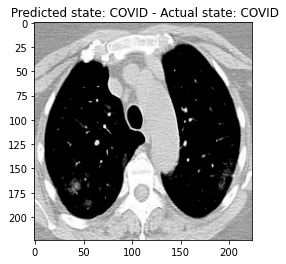

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


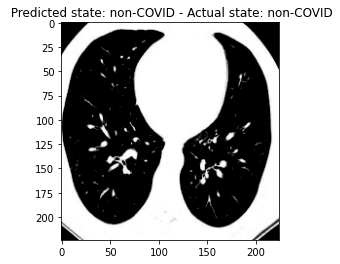

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


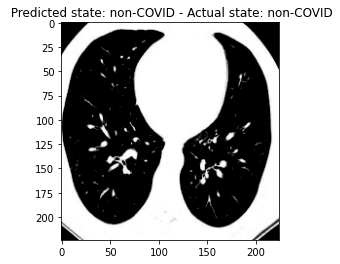

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


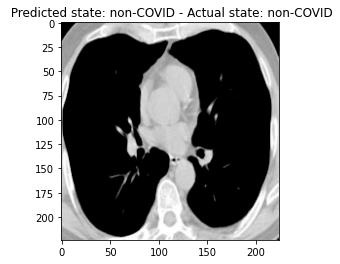

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


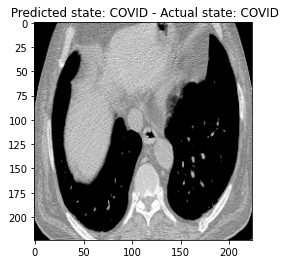

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


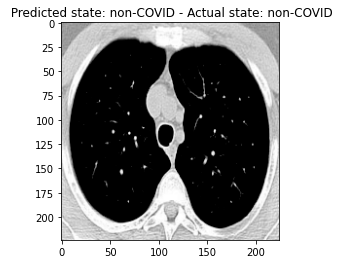

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


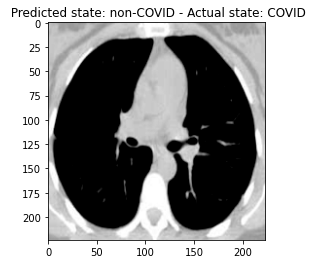

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


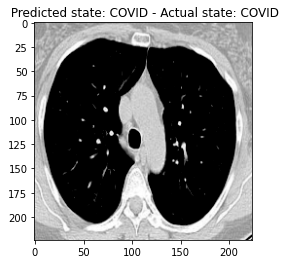

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


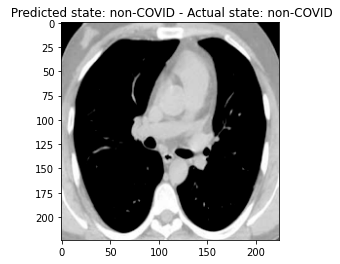

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


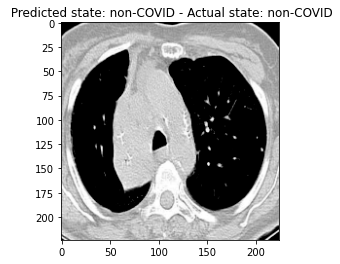

In [17]:
import random

correct = 0
total = 0
total_losss =0
true_value = 0 
with torch.no_grad():

    for data, target in testloader:
        images = data.to(device)
        labels = target.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_losss += loss.item()

        accuracy = correct / total

    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
    
    
    for f in range(10):
                   
        index = random.randint(0, 247)
        item = test[index]
        image = item[0]
        image = image.reshape(1,3,224,224)
        true_target = item[1]
        
        image = image.to(device)

        the_model.eval()

        prediction = the_model(image)

        predicted_class = np.argmax(prediction.cpu())
        
        if (predicted_class == 1):
            predicted_label = 'non-COVID'
        else:
            predicted_label = 'COVID'
            
        if (true_target == 1):
            true_label = 'non-COVID'
        else:
            true_label = 'COVID'

        input_picture = item[0].permute(1,2,0)


        plt.imshow(input_picture,cmap='gray')
        plt.title(f' Predicted state: {predicted_label} - Actual state: {true_label}')
        plt.show()